In [1]:
import os, json, sys, time, random
import numpy as np
import torch
from  easydict import EasyDict
from math import floor
from easydict import EasyDict

from steves_utils.vanilla_train_eval_test_jig import  Vanilla_Train_Eval_Test_Jig

from steves_utils.torch_utils import get_dataset_metrics, independent_accuracy_assesment
from steves_models.configurable_vanilla import Configurable_Vanilla
from steves_utils.torch_sequential_builder import build_sequential
from steves_utils.lazy_map import Lazy_Map
from steves_utils.sequence_aggregator import Sequence_Aggregator

from steves_utils.stratified_dataset.traditional_accessor import Traditional_Accessor_Factory

from steves_utils.cnn_do_report import (
    get_loss_curve,
    get_results_table,
    get_parameters_table,
    get_domain_accuracies,
)

from steves_utils.torch_utils import (
    confusion_by_domain_over_dataloader,
    independent_accuracy_assesment
)

from steves_utils.utils_v2 import (
    per_domain_accuracy_from_confusion,
    get_datasets_base_path
)

# from steves_utils.ptn_do_report import TBD

In [2]:
required_parameters = {
    "experiment_name",
    "lr",
    "device",
    "dataset_seed",
    "seed",
    "labels",
    "domains_target",
    "domains_source",
    "num_examples_per_domain_per_label_source",
    "num_examples_per_domain_per_label_target",
    "batch_size",
    "n_epoch",
    "patience",
    "criteria_for_best",
    "normalize_source",
    "normalize_target",
    "x_net",
    "NUM_LOGS_PER_EPOCH",
    "BEST_MODEL_PATH",
    "pickle_name_source",
    "pickle_name_target",
    "torch_default_dtype",
}

In [3]:
from steves_utils.ORACLE.utils_v2 import (
    ALL_SERIAL_NUMBERS,
    ALL_DISTANCES_FEET_NARROWED,
)

standalone_parameters = {}
standalone_parameters["experiment_name"] = "MANUAL CORES CNN"
standalone_parameters["lr"] = 0.0001
standalone_parameters["device"] = "cuda"

standalone_parameters["dataset_seed"] = 1337
standalone_parameters["seed"] = 1337
standalone_parameters["labels"] = ALL_SERIAL_NUMBERS

standalone_parameters["domains_source"] = [8,32,50]
standalone_parameters["domains_target"] = [14,20,26,38,44,]

standalone_parameters["num_examples_per_domain_per_label_source"]=-1
standalone_parameters["num_examples_per_domain_per_label_target"]=-1

standalone_parameters["pickle_name_source"] = "oracle.Run1_framed_2000Examples_stratified_ds.2022A.pkl"
standalone_parameters["pickle_name_target"] = "oracle.Run2_framed_2000Examples_stratified_ds.2022A.pkl"

standalone_parameters["torch_default_dtype"] = "torch.float32" 

standalone_parameters["batch_size"]=128

standalone_parameters["n_epoch"] = 3

standalone_parameters["patience"] = 10

standalone_parameters["criteria_for_best"] = "target_accuracy"
standalone_parameters["normalize_source"] = False
standalone_parameters["normalize_target"] = False

standalone_parameters["x_net"] =     [
    {"class": "nnReshape", "kargs": {"shape":[-1, 1, 2, 256]}},
    {"class": "Conv2d", "kargs": { "in_channels":1, "out_channels":256, "kernel_size":(1,7), "bias":False, "padding":(0,3), },},
    {"class": "ReLU", "kargs": {"inplace": True}},
    {"class": "BatchNorm2d", "kargs": {"num_features":256}},

    {"class": "Conv2d", "kargs": { "in_channels":256, "out_channels":80, "kernel_size":(2,7), "bias":True, "padding":(0,3), },},
    {"class": "ReLU", "kargs": {"inplace": True}},
    {"class": "BatchNorm2d", "kargs": {"num_features":80}},
    {"class": "Flatten", "kargs": {}},

    {"class": "Linear", "kargs": {"in_features": 80*256, "out_features": 256}}, # 80 units per IQ pair
    {"class": "ReLU", "kargs": {"inplace": True}},
    {"class": "BatchNorm1d", "kargs": {"num_features":256}},

    {"class": "Linear", "kargs": {"in_features": 256, "out_features": len(standalone_parameters["labels"])}},
]

standalone_parameters["NUM_LOGS_PER_EPOCH"] = 10
standalone_parameters["BEST_MODEL_PATH"] = "./best_model.pth"

In [4]:
# Parameters
parameters = {
    "experiment_name": "cnn_3:oracle.run1.framed-oracle.run2.framed",
    "labels": [
        "3123D52",
        "3123D65",
        "3123D79",
        "3123D80",
        "3123D54",
        "3123D70",
        "3123D7B",
        "3123D89",
        "3123D58",
        "3123D76",
        "3123D7D",
        "3123EFE",
        "3123D64",
        "3123D78",
        "3123D7E",
        "3124E4A",
    ],
    "domains_source": [8, 32, 50, 14, 20, 26, 38, 44],
    "domains_target": [8, 32, 50, 14, 20, 26, 38, 44],
    "pickle_name_source": "oracle.Run1_framed_2000Examples_stratified_ds.2022A.pkl",
    "pickle_name_target": "oracle.Run2_framed_2000Examples_stratified_ds.2022A.pkl",
    "device": "cuda",
    "lr": 0.0001,
    "batch_size": 128,
    "normalize_source": False,
    "normalize_target": False,
    "num_examples_per_domain_per_label_source": -1,
    "num_examples_per_domain_per_label_target": -1,
    "torch_default_dtype": "torch.float32",
    "n_epoch": 50,
    "patience": 3,
    "criteria_for_best": "target_accuracy",
    "x_net": [
        {"class": "nnReshape", "kargs": {"shape": [-1, 1, 2, 256]}},
        {
            "class": "Conv2d",
            "kargs": {
                "in_channels": 1,
                "out_channels": 256,
                "kernel_size": [1, 7],
                "bias": False,
                "padding": [0, 3],
            },
        },
        {"class": "ReLU", "kargs": {"inplace": True}},
        {"class": "BatchNorm2d", "kargs": {"num_features": 256}},
        {
            "class": "Conv2d",
            "kargs": {
                "in_channels": 256,
                "out_channels": 80,
                "kernel_size": [2, 7],
                "bias": True,
                "padding": [0, 3],
            },
        },
        {"class": "ReLU", "kargs": {"inplace": True}},
        {"class": "BatchNorm2d", "kargs": {"num_features": 80}},
        {"class": "Flatten", "kargs": {}},
        {"class": "Linear", "kargs": {"in_features": 20480, "out_features": 256}},
        {"class": "ReLU", "kargs": {"inplace": True}},
        {"class": "BatchNorm1d", "kargs": {"num_features": 256}},
        {"class": "Linear", "kargs": {"in_features": 256, "out_features": 16}},
    ],
    "NUM_LOGS_PER_EPOCH": 10,
    "BEST_MODEL_PATH": "./best_model.pth",
    "dataset_seed": 420,
    "seed": 420,
}


In [5]:
# Set this to True if you want to run this template directly
STANDALONE = False
if STANDALONE:
    print("parameters not injected, running with standalone_parameters")
    parameters = standalone_parameters

if not 'parameters' in locals() and not 'parameters' in globals():
    raise Exception("Parameter injection failed")

#Use an easy dict for all the parameters
p = EasyDict(parameters)

supplied_keys = set(p.keys())

if  supplied_keys != required_parameters:
    print("Parameters are incorrect")
    if len(supplied_keys - required_parameters)>0: print("Shouldn't have:", str(supplied_keys - required_parameters))
    if len(required_parameters - supplied_keys)>0: print("Need to have:", str(required_parameters - supplied_keys))
    raise RuntimeError("Parameters are incorrect")



In [6]:
###################################
# Set the RNGs and make it all deterministic
###################################
np.random.seed(p.seed)
random.seed(p.seed)
torch.manual_seed(p.seed)

torch.use_deterministic_algorithms(True) 

In [7]:
torch.set_default_dtype(eval(p.torch_default_dtype))

In [8]:
###################################
# Build the network(s)
# Note: It's critical to do this AFTER setting the RNG
###################################
x_net = build_sequential(p.x_net)

In [9]:
start_time_secs = time.time()

In [10]:
def wrap_in_dataloader(p, ds):
    return torch.utils.data.DataLoader(
        ds,
        batch_size=p.batch_size,
        shuffle=True,
        num_workers=1,
        persistent_workers=True,
        prefetch_factor=50,
        pin_memory=True
    )

taf_source = Traditional_Accessor_Factory(
    labels=p.labels,
    domains=p.domains_source,
    num_examples_per_domain_per_label=p.num_examples_per_domain_per_label_source,
    pickle_path=os.path.join(get_datasets_base_path(), p.pickle_name_source),
    seed=p.dataset_seed
)
train_original_source, val_original_source, test_original_source = \
    taf_source.get_train(), taf_source.get_val(), taf_source.get_test()


taf_target = Traditional_Accessor_Factory(
    labels=p.labels,
    domains=p.domains_target,
    num_examples_per_domain_per_label=p.num_examples_per_domain_per_label_source,
    pickle_path=os.path.join(get_datasets_base_path(), p.pickle_name_target),
    seed=p.dataset_seed
)
train_original_target, val_original_target, test_original_target = \
    taf_target.get_train(), taf_target.get_val(), taf_target.get_test()


# For CNN We only use X and Y. And we only train on the source.
# Properly form the data using a transform lambda and Lazy_Map. Finally wrap them in a dataloader

transform_lambda = lambda ex: ex[:2] # Strip the tuple to just (x,y)


train_processed_source = wrap_in_dataloader(
    p,
    Lazy_Map(train_original_source, transform_lambda)
)
val_processed_source = wrap_in_dataloader(
    p,
    Lazy_Map(val_original_source, transform_lambda)
)
test_processed_source = wrap_in_dataloader(
    p,
    Lazy_Map(test_original_source, transform_lambda)
)

train_processed_target = wrap_in_dataloader(
    p,
    Lazy_Map(train_original_target, transform_lambda)
)
val_processed_target = wrap_in_dataloader(
    p,
    Lazy_Map(val_original_target, transform_lambda)
)
test_processed_target  = wrap_in_dataloader(
    p,
    Lazy_Map(test_original_target, transform_lambda)
)



datasets = EasyDict({
    "source": {
        "original": {"train":train_original_source, "val":val_original_source, "test":test_original_source},
        "processed": {"train":train_processed_source, "val":val_processed_source, "test":test_processed_source}
    },
    "target": {
        "original": {"train":train_original_target, "val":val_original_target, "test":test_original_target},
        "processed": {"train":train_processed_target, "val":val_processed_target, "test":test_processed_target}
    },
})

In [11]:
ep = next(iter(test_processed_target))
ep[0].dtype

torch.float32

In [12]:
model = Configurable_Vanilla(
    x_net=x_net,
    label_loss_object=torch.nn.NLLLoss(),
    learning_rate=p.lr
)

In [13]:
jig = Vanilla_Train_Eval_Test_Jig(
    model=model,
    path_to_best_model=p.BEST_MODEL_PATH,
    device=p.device,
    label_loss_object=torch.nn.NLLLoss(),
)

jig.train(
    train_iterable=datasets.source.processed.train,
    source_val_iterable=datasets.source.processed.val,
    target_val_iterable=datasets.target.processed.val,
    patience=p.patience,
    num_epochs=p.n_epoch,
    num_logs_per_epoch=p.NUM_LOGS_PER_EPOCH,
    criteria_for_best=p.criteria_for_best
)

epoch: 1, [batch: 1 / 1400], examples_per_second: 591.2213, train_label_loss: 2.8216, 


epoch: 1, [batch: 140 / 1400], examples_per_second: 11671.9520, train_label_loss: 2.7149, 


epoch: 1, [batch: 280 / 1400], examples_per_second: 11791.1402, train_label_loss: 2.6033, 


epoch: 1, [batch: 420 / 1400], examples_per_second: 11667.0921, train_label_loss: 2.5202, 


epoch: 1, [batch: 560 / 1400], examples_per_second: 11653.2939, train_label_loss: 2.2961, 


epoch: 1, [batch: 700 / 1400], examples_per_second: 11739.7772, train_label_loss: 2.1301, 


epoch: 1, [batch: 840 / 1400], examples_per_second: 11657.7294, train_label_loss: 2.0507, 


epoch: 1, [batch: 980 / 1400], examples_per_second: 11655.1479, train_label_loss: 1.7957, 


epoch: 1, [batch: 1120 / 1400], examples_per_second: 11691.5434, train_label_loss: 1.7544, 


epoch: 1, [batch: 1260 / 1400], examples_per_second: 11513.3401, train_label_loss: 1.4919, 


epoch: 1, source_val_acc_label: 0.6123, source_val_label_loss: 1.3601, target_val_acc_label: 0.5710, target_val_label_loss: 1.4615, 


New best
epoch: 2, [batch: 1 / 1400], examples_per_second: 54.1163, train_label_loss: 1.4574, 


epoch: 2, [batch: 140 / 1400], examples_per_second: 11632.7754, train_label_loss: 1.3813, 


epoch: 2, [batch: 280 / 1400], examples_per_second: 11602.4237, train_label_loss: 1.2111, 


epoch: 2, [batch: 420 / 1400], examples_per_second: 11670.4182, train_label_loss: 1.1166, 


epoch: 2, [batch: 560 / 1400], examples_per_second: 11720.5040, train_label_loss: 1.1297, 


epoch: 2, [batch: 700 / 1400], examples_per_second: 11682.6588, train_label_loss: 0.9913, 


epoch: 2, [batch: 840 / 1400], examples_per_second: 11670.4345, train_label_loss: 0.9396, 


epoch: 2, [batch: 980 / 1400], examples_per_second: 11691.5543, train_label_loss: 0.9316, 


epoch: 2, [batch: 1120 / 1400], examples_per_second: 11634.1953, train_label_loss: 0.7211, 


epoch: 2, [batch: 1260 / 1400], examples_per_second: 11562.9359, train_label_loss: 0.6586, 


epoch: 2, source_val_acc_label: 0.8549, source_val_label_loss: 0.6369, target_val_acc_label: 0.7765, target_val_label_loss: 0.8560, 


New best
epoch: 3, [batch: 1 / 1400], examples_per_second: 64.2010, train_label_loss: 0.7573, 


epoch: 3, [batch: 140 / 1400], examples_per_second: 11496.7762, train_label_loss: 0.6301, 


epoch: 3, [batch: 280 / 1400], examples_per_second: 11709.9898, train_label_loss: 0.6593, 


epoch: 3, [batch: 420 / 1400], examples_per_second: 12981.3190, train_label_loss: 0.6105, 


epoch: 3, [batch: 560 / 1400], examples_per_second: 12832.9687, train_label_loss: 0.5531, 


epoch: 3, [batch: 700 / 1400], examples_per_second: 12756.7563, train_label_loss: 0.4198, 


epoch: 3, [batch: 840 / 1400], examples_per_second: 12680.0937, train_label_loss: 0.4471, 


epoch: 3, [batch: 980 / 1400], examples_per_second: 12817.0069, train_label_loss: 0.4533, 


epoch: 3, [batch: 1120 / 1400], examples_per_second: 12855.9393, train_label_loss: 0.4251, 


epoch: 3, [batch: 1260 / 1400], examples_per_second: 12551.6666, train_label_loss: 0.4470, 


epoch: 3, source_val_acc_label: 0.9046, source_val_label_loss: 0.3884, target_val_acc_label: 0.8097, target_val_label_loss: 0.6580, 


New best
epoch: 4, [batch: 1 / 1400], examples_per_second: 71.8154, train_label_loss: 0.3236, 


epoch: 4, [batch: 140 / 1400], examples_per_second: 12420.1957, train_label_loss: 0.3472, 


epoch: 4, [batch: 280 / 1400], examples_per_second: 12658.3414, train_label_loss: 0.3789, 


epoch: 4, [batch: 420 / 1400], examples_per_second: 12661.0153, train_label_loss: 0.3031, 


epoch: 4, [batch: 560 / 1400], examples_per_second: 12752.2111, train_label_loss: 0.8126, 


epoch: 4, [batch: 700 / 1400], examples_per_second: 12635.6100, train_label_loss: 0.3123, 


epoch: 4, [batch: 840 / 1400], examples_per_second: 12644.6825, train_label_loss: 0.4826, 


epoch: 4, [batch: 980 / 1400], examples_per_second: 12780.7171, train_label_loss: 0.3568, 


epoch: 4, [batch: 1120 / 1400], examples_per_second: 12722.3352, train_label_loss: 0.4031, 


epoch: 4, [batch: 1260 / 1400], examples_per_second: 12996.1871, train_label_loss: 0.3626, 


epoch: 4, source_val_acc_label: 0.9237, source_val_label_loss: 0.2948, target_val_acc_label: 0.8345, target_val_label_loss: 0.5795, 


New best
epoch: 5, [batch: 1 / 1400], examples_per_second: 71.0814, train_label_loss: 0.3152, 


epoch: 5, [batch: 140 / 1400], examples_per_second: 12931.5126, train_label_loss: 0.3342, 


epoch: 5, [batch: 280 / 1400], examples_per_second: 13662.3199, train_label_loss: 0.3700, 


epoch: 5, [batch: 420 / 1400], examples_per_second: 12991.7101, train_label_loss: 0.3175, 


epoch: 5, [batch: 560 / 1400], examples_per_second: 12802.0092, train_label_loss: 0.3126, 


epoch: 5, [batch: 700 / 1400], examples_per_second: 12980.5836, train_label_loss: 0.4035, 


epoch: 5, [batch: 840 / 1400], examples_per_second: 12956.5673, train_label_loss: 0.2009, 


epoch: 5, [batch: 980 / 1400], examples_per_second: 12873.0256, train_label_loss: 0.3454, 


epoch: 5, [batch: 1120 / 1400], examples_per_second: 13000.5593, train_label_loss: 0.2664, 


epoch: 5, [batch: 1260 / 1400], examples_per_second: 12982.7181, train_label_loss: 0.2881, 


epoch: 5, source_val_acc_label: 0.9340, source_val_label_loss: 0.2551, target_val_acc_label: 0.8351, target_val_label_loss: 0.5540, 


New best
epoch: 6, [batch: 1 / 1400], examples_per_second: 72.6348, train_label_loss: 0.2459, 


epoch: 6, [batch: 140 / 1400], examples_per_second: 12854.4300, train_label_loss: 0.2756, 


epoch: 6, [batch: 280 / 1400], examples_per_second: 12793.0253, train_label_loss: 0.2464, 


epoch: 6, [batch: 420 / 1400], examples_per_second: 12913.4044, train_label_loss: 0.3513, 


epoch: 6, [batch: 560 / 1400], examples_per_second: 12788.0670, train_label_loss: 0.1501, 


epoch: 6, [batch: 700 / 1400], examples_per_second: 12991.2295, train_label_loss: 0.1779, 


epoch: 6, [batch: 840 / 1400], examples_per_second: 12543.7485, train_label_loss: 0.2939, 


epoch: 6, [batch: 980 / 1400], examples_per_second: 13021.3703, train_label_loss: 0.3865, 


epoch: 6, [batch: 1120 / 1400], examples_per_second: 12887.9140, train_label_loss: 0.2128, 


epoch: 6, [batch: 1260 / 1400], examples_per_second: 12924.8137, train_label_loss: 0.2631, 


epoch: 6, source_val_acc_label: 0.9301, source_val_label_loss: 0.2279, target_val_acc_label: 0.8456, target_val_label_loss: 0.5668, 


New best
epoch: 7, [batch: 1 / 1400], examples_per_second: 72.8087, train_label_loss: 0.2471, 


epoch: 7, [batch: 140 / 1400], examples_per_second: 16669.3785, train_label_loss: 0.2604, 


epoch: 7, [batch: 280 / 1400], examples_per_second: 17052.3797, train_label_loss: 0.1593, 


epoch: 7, [batch: 420 / 1400], examples_per_second: 16889.2126, train_label_loss: 0.2438, 


epoch: 7, [batch: 560 / 1400], examples_per_second: 16918.3026, train_label_loss: 0.2972, 


epoch: 7, [batch: 700 / 1400], examples_per_second: 17012.2124, train_label_loss: 0.1802, 


epoch: 7, [batch: 840 / 1400], examples_per_second: 13092.2685, train_label_loss: 0.2435, 


epoch: 7, [batch: 980 / 1400], examples_per_second: 12823.6109, train_label_loss: 0.2200, 


epoch: 7, [batch: 1120 / 1400], examples_per_second: 12823.2127, train_label_loss: 0.2741, 


epoch: 7, [batch: 1260 / 1400], examples_per_second: 12892.5719, train_label_loss: 0.2090, 


epoch: 7, source_val_acc_label: 0.9484, source_val_label_loss: 0.1768, target_val_acc_label: 0.8481, target_val_label_loss: 0.6565, 


New best
epoch: 8, [batch: 1 / 1400], examples_per_second: 68.0806, train_label_loss: 0.1899, 


epoch: 8, [batch: 140 / 1400], examples_per_second: 12728.2546, train_label_loss: 0.2294, 


epoch: 8, [batch: 280 / 1400], examples_per_second: 12763.2289, train_label_loss: 0.1945, 


epoch: 8, [batch: 420 / 1400], examples_per_second: 12702.9793, train_label_loss: 0.1402, 


epoch: 8, [batch: 560 / 1400], examples_per_second: 12674.0150, train_label_loss: 0.1517, 


epoch: 8, [batch: 700 / 1400], examples_per_second: 12697.5220, train_label_loss: 0.1565, 


epoch: 8, [batch: 840 / 1400], examples_per_second: 12780.5911, train_label_loss: 0.1416, 


epoch: 8, [batch: 980 / 1400], examples_per_second: 12533.7959, train_label_loss: 0.1714, 


epoch: 8, [batch: 1120 / 1400], examples_per_second: 12821.6290, train_label_loss: 0.2177, 


epoch: 8, [batch: 1260 / 1400], examples_per_second: 12758.4973, train_label_loss: 0.2893, 


epoch: 8, source_val_acc_label: 0.9390, source_val_label_loss: 0.1943, target_val_acc_label: 0.8428, target_val_label_loss: 0.6521, 


epoch: 9, [batch: 1 / 1400], examples_per_second: 71.0287, train_label_loss: 0.3681, 


epoch: 9, [batch: 140 / 1400], examples_per_second: 12633.9848, train_label_loss: 0.1361, 


epoch: 9, [batch: 280 / 1400], examples_per_second: 12725.1331, train_label_loss: 0.1280, 


epoch: 9, [batch: 420 / 1400], examples_per_second: 12446.6078, train_label_loss: 0.1206, 


epoch: 9, [batch: 560 / 1400], examples_per_second: 12567.8754, train_label_loss: 0.1866, 


epoch: 9, [batch: 700 / 1400], examples_per_second: 12342.7802, train_label_loss: 0.1760, 


epoch: 9, [batch: 840 / 1400], examples_per_second: 12689.4081, train_label_loss: 0.2076, 


epoch: 9, [batch: 980 / 1400], examples_per_second: 12617.2560, train_label_loss: 0.1808, 


epoch: 9, [batch: 1120 / 1400], examples_per_second: 12450.6056, train_label_loss: 0.1793, 


epoch: 9, [batch: 1260 / 1400], examples_per_second: 12800.1038, train_label_loss: 0.1955, 


epoch: 9, source_val_acc_label: 0.9485, source_val_label_loss: 0.1794, target_val_acc_label: 0.8540, target_val_label_loss: 0.7443, 


New best
epoch: 10, [batch: 1 / 1400], examples_per_second: 70.0571, train_label_loss: 0.2457, 


epoch: 10, [batch: 140 / 1400], examples_per_second: 12441.7106, train_label_loss: 0.1949, 


epoch: 10, [batch: 280 / 1400], examples_per_second: 12576.5900, train_label_loss: 0.1351, 


epoch: 10, [batch: 420 / 1400], examples_per_second: 12244.8722, train_label_loss: 0.0869, 


epoch: 10, [batch: 560 / 1400], examples_per_second: 12721.0820, train_label_loss: 0.1133, 


epoch: 10, [batch: 700 / 1400], examples_per_second: 12802.5130, train_label_loss: 0.0793, 


epoch: 10, [batch: 840 / 1400], examples_per_second: 12571.3670, train_label_loss: 0.1326, 


epoch: 10, [batch: 980 / 1400], examples_per_second: 12519.3407, train_label_loss: 0.1144, 


epoch: 10, [batch: 1120 / 1400], examples_per_second: 12196.3945, train_label_loss: 0.1758, 


epoch: 10, [batch: 1260 / 1400], examples_per_second: 12547.0235, train_label_loss: 0.1219, 


epoch: 10, source_val_acc_label: 0.9444, source_val_label_loss: 0.1830, target_val_acc_label: 0.8476, target_val_label_loss: 0.6348, 


epoch: 11, [batch: 1 / 1400], examples_per_second: 71.2265, train_label_loss: 0.1174, 


epoch: 11, [batch: 140 / 1400], examples_per_second: 12737.0096, train_label_loss: 0.1557, 


epoch: 11, [batch: 280 / 1400], examples_per_second: 12444.7880, train_label_loss: 0.0461, 


epoch: 11, [batch: 420 / 1400], examples_per_second: 12773.8403, train_label_loss: 0.2169, 


epoch: 11, [batch: 560 / 1400], examples_per_second: 12610.9009, train_label_loss: 0.1612, 


epoch: 11, [batch: 700 / 1400], examples_per_second: 12444.5305, train_label_loss: 0.1249, 


epoch: 11, [batch: 840 / 1400], examples_per_second: 12770.1660, train_label_loss: 0.0829, 


epoch: 11, [batch: 980 / 1400], examples_per_second: 12619.6816, train_label_loss: 0.0922, 


epoch: 11, [batch: 1120 / 1400], examples_per_second: 12592.2789, train_label_loss: 0.1653, 


epoch: 11, [batch: 1260 / 1400], examples_per_second: 12656.9751, train_label_loss: 0.1196, 


epoch: 11, source_val_acc_label: 0.9536, source_val_label_loss: 0.1561, target_val_acc_label: 0.8551, target_val_label_loss: 0.6199, 


New best
epoch: 12, [batch: 1 / 1400], examples_per_second: 71.4007, train_label_loss: 0.1093, 


epoch: 12, [batch: 140 / 1400], examples_per_second: 12710.3303, train_label_loss: 0.1189, 


epoch: 12, [batch: 280 / 1400], examples_per_second: 12737.7143, train_label_loss: 0.1575, 


epoch: 12, [batch: 420 / 1400], examples_per_second: 12633.7983, train_label_loss: 0.0779, 


epoch: 12, [batch: 560 / 1400], examples_per_second: 12769.4977, train_label_loss: 0.1102, 


epoch: 12, [batch: 700 / 1400], examples_per_second: 12857.7295, train_label_loss: 0.1757, 


epoch: 12, [batch: 840 / 1400], examples_per_second: 11686.2608, train_label_loss: 0.1201, 


epoch: 12, [batch: 980 / 1400], examples_per_second: 12641.7965, train_label_loss: 0.1854, 


epoch: 12, [batch: 1120 / 1400], examples_per_second: 12644.8804, train_label_loss: 0.0929, 


epoch: 12, [batch: 1260 / 1400], examples_per_second: 12699.7146, train_label_loss: 0.1262, 


epoch: 12, source_val_acc_label: 0.9524, source_val_label_loss: 0.1406, target_val_acc_label: 0.8539, target_val_label_loss: 0.5759, 


epoch: 13, [batch: 1 / 1400], examples_per_second: 67.5773, train_label_loss: 0.1782, 


epoch: 13, [batch: 140 / 1400], examples_per_second: 12653.9897, train_label_loss: 0.1204, 


epoch: 13, [batch: 280 / 1400], examples_per_second: 12600.5373, train_label_loss: 0.1194, 


epoch: 13, [batch: 420 / 1400], examples_per_second: 12728.8570, train_label_loss: 0.1100, 


epoch: 13, [batch: 560 / 1400], examples_per_second: 12662.5746, train_label_loss: 0.1178, 


epoch: 13, [batch: 700 / 1400], examples_per_second: 12828.9231, train_label_loss: 0.1166, 


epoch: 13, [batch: 840 / 1400], examples_per_second: 12531.9088, train_label_loss: 0.1143, 


epoch: 13, [batch: 980 / 1400], examples_per_second: 12378.7809, train_label_loss: 0.2219, 


epoch: 13, [batch: 1120 / 1400], examples_per_second: 12609.0117, train_label_loss: 0.1586, 


epoch: 13, [batch: 1260 / 1400], examples_per_second: 12690.9229, train_label_loss: 0.0872, 


epoch: 13, source_val_acc_label: 0.9608, source_val_label_loss: 0.1349, target_val_acc_label: 0.8575, target_val_label_loss: 0.6142, 


New best
epoch: 14, [batch: 1 / 1400], examples_per_second: 70.0494, train_label_loss: 0.1013, 


epoch: 14, [batch: 140 / 1400], examples_per_second: 12895.5709, train_label_loss: 0.1695, 


epoch: 14, [batch: 280 / 1400], examples_per_second: 12817.2976, train_label_loss: 0.1062, 


epoch: 14, [batch: 420 / 1400], examples_per_second: 12685.6666, train_label_loss: 0.0867, 


epoch: 14, [batch: 560 / 1400], examples_per_second: 12729.7797, train_label_loss: 0.1172, 


epoch: 14, [batch: 700 / 1400], examples_per_second: 12682.6035, train_label_loss: 0.1181, 


epoch: 14, [batch: 840 / 1400], examples_per_second: 12843.0095, train_label_loss: 0.1163, 


epoch: 14, [batch: 980 / 1400], examples_per_second: 12764.7961, train_label_loss: 0.1292, 


epoch: 14, [batch: 1120 / 1400], examples_per_second: 12555.5665, train_label_loss: 0.0688, 


epoch: 14, [batch: 1260 / 1400], examples_per_second: 12842.7790, train_label_loss: 0.1010, 


epoch: 14, source_val_acc_label: 0.9517, source_val_label_loss: 0.1445, target_val_acc_label: 0.8538, target_val_label_loss: 0.5699, 


epoch: 15, [batch: 1 / 1400], examples_per_second: 69.3526, train_label_loss: 0.1342, 


epoch: 15, [batch: 140 / 1400], examples_per_second: 12470.9107, train_label_loss: 0.1132, 


epoch: 15, [batch: 280 / 1400], examples_per_second: 12659.3179, train_label_loss: 0.1194, 


epoch: 15, [batch: 420 / 1400], examples_per_second: 12694.1187, train_label_loss: 0.0575, 


epoch: 15, [batch: 560 / 1400], examples_per_second: 12620.4953, train_label_loss: 0.0764, 


epoch: 15, [batch: 700 / 1400], examples_per_second: 12545.8800, train_label_loss: 0.0740, 


epoch: 15, [batch: 840 / 1400], examples_per_second: 12697.7880, train_label_loss: 0.1165, 


epoch: 15, [batch: 980 / 1400], examples_per_second: 12619.0418, train_label_loss: 0.0648, 


epoch: 15, [batch: 1120 / 1400], examples_per_second: 12604.8016, train_label_loss: 0.0685, 


epoch: 15, [batch: 1260 / 1400], examples_per_second: 12569.2983, train_label_loss: 0.1232, 


epoch: 15, source_val_acc_label: 0.9585, source_val_label_loss: 0.1249, target_val_acc_label: 0.8506, target_val_label_loss: 0.6029, 


epoch: 16, [batch: 1 / 1400], examples_per_second: 70.8133, train_label_loss: 0.1415, 


epoch: 16, [batch: 140 / 1400], examples_per_second: 12826.3752, train_label_loss: 0.0983, 


epoch: 16, [batch: 280 / 1400], examples_per_second: 12750.4394, train_label_loss: 0.1284, 


epoch: 16, [batch: 420 / 1400], examples_per_second: 12741.0503, train_label_loss: 0.1327, 


epoch: 16, [batch: 560 / 1400], examples_per_second: 12856.6782, train_label_loss: 0.0997, 


epoch: 16, [batch: 700 / 1400], examples_per_second: 12658.9128, train_label_loss: 0.1327, 


epoch: 16, [batch: 840 / 1400], examples_per_second: 12748.8801, train_label_loss: 0.0957, 


epoch: 16, [batch: 980 / 1400], examples_per_second: 12683.5345, train_label_loss: 0.1257, 


epoch: 16, [batch: 1120 / 1400], examples_per_second: 12427.5386, train_label_loss: 0.1626, 


epoch: 16, [batch: 1260 / 1400], examples_per_second: 12665.8799, train_label_loss: 0.0676, 


epoch: 16, source_val_acc_label: 0.9581, source_val_label_loss: 0.1403, target_val_acc_label: 0.8593, target_val_label_loss: 0.6117, 


New best
epoch: 17, [batch: 1 / 1400], examples_per_second: 71.0770, train_label_loss: 0.0942, 


epoch: 17, [batch: 140 / 1400], examples_per_second: 12670.6365, train_label_loss: 0.1657, 


epoch: 17, [batch: 280 / 1400], examples_per_second: 12698.1398, train_label_loss: 0.0672, 


epoch: 17, [batch: 420 / 1400], examples_per_second: 12679.7600, train_label_loss: 0.1132, 


epoch: 17, [batch: 560 / 1400], examples_per_second: 12763.0555, train_label_loss: 0.1381, 


epoch: 17, [batch: 700 / 1400], examples_per_second: 12519.8850, train_label_loss: 0.1372, 


epoch: 17, [batch: 840 / 1400], examples_per_second: 12509.6308, train_label_loss: 0.2511, 


epoch: 17, [batch: 980 / 1400], examples_per_second: 12801.9656, train_label_loss: 0.1137, 


epoch: 17, [batch: 1120 / 1400], examples_per_second: 12625.2397, train_label_loss: 0.1426, 


epoch: 17, [batch: 1260 / 1400], examples_per_second: 12743.4222, train_label_loss: 0.0703, 


epoch: 17, source_val_acc_label: 0.9596, source_val_label_loss: 0.3663, target_val_acc_label: 0.8564, target_val_label_loss: 1.2324, 


epoch: 18, [batch: 1 / 1400], examples_per_second: 70.4908, train_label_loss: 0.0540, 


epoch: 18, [batch: 140 / 1400], examples_per_second: 12583.5860, train_label_loss: 0.0557, 


epoch: 18, [batch: 280 / 1400], examples_per_second: 12826.4229, train_label_loss: 0.0628, 


epoch: 18, [batch: 420 / 1400], examples_per_second: 12862.5152, train_label_loss: 0.0976, 


epoch: 18, [batch: 560 / 1400], examples_per_second: 12566.6903, train_label_loss: 0.0792, 


epoch: 18, [batch: 700 / 1400], examples_per_second: 12783.6256, train_label_loss: 0.0964, 


epoch: 18, [batch: 840 / 1400], examples_per_second: 12606.4675, train_label_loss: 0.0676, 


epoch: 18, [batch: 980 / 1400], examples_per_second: 12802.4454, train_label_loss: 0.0666, 


epoch: 18, [batch: 1120 / 1400], examples_per_second: 12786.4419, train_label_loss: 0.0957, 


epoch: 18, [batch: 1260 / 1400], examples_per_second: 12495.8213, train_label_loss: 0.0828, 


epoch: 18, source_val_acc_label: 0.9621, source_val_label_loss: 0.2046, target_val_acc_label: 0.8532, target_val_label_loss: 0.9064, 


epoch: 19, [batch: 1 / 1400], examples_per_second: 69.4527, train_label_loss: 0.0660, 


epoch: 19, [batch: 140 / 1400], examples_per_second: 12629.7960, train_label_loss: 0.1108, 


epoch: 19, [batch: 280 / 1400], examples_per_second: 12692.6224, train_label_loss: 0.0722, 


epoch: 19, [batch: 420 / 1400], examples_per_second: 12631.6644, train_label_loss: 0.1064, 


epoch: 19, [batch: 560 / 1400], examples_per_second: 12765.7587, train_label_loss: 0.1036, 


epoch: 19, [batch: 700 / 1400], examples_per_second: 12771.4180, train_label_loss: 0.0758, 


epoch: 19, [batch: 840 / 1400], examples_per_second: 12873.4313, train_label_loss: 0.1244, 


epoch: 19, [batch: 980 / 1400], examples_per_second: 12691.5358, train_label_loss: 0.0839, 


epoch: 19, [batch: 1120 / 1400], examples_per_second: 12704.9225, train_label_loss: 0.0660, 


epoch: 19, [batch: 1260 / 1400], examples_per_second: 12889.7484, train_label_loss: 0.0453, 


epoch: 19, source_val_acc_label: 0.9486, source_val_label_loss: 0.1988, target_val_acc_label: 0.8509, target_val_label_loss: 0.8938, 


epoch: 20, [batch: 1 / 1400], examples_per_second: 67.1837, train_label_loss: 0.0787, 


epoch: 20, [batch: 140 / 1400], examples_per_second: 12316.1177, train_label_loss: 0.0661, 


epoch: 20, [batch: 280 / 1400], examples_per_second: 12493.1939, train_label_loss: 0.0752, 


epoch: 20, [batch: 420 / 1400], examples_per_second: 12342.6464, train_label_loss: 0.0473, 


epoch: 20, [batch: 560 / 1400], examples_per_second: 12499.0318, train_label_loss: 0.0481, 


epoch: 20, [batch: 700 / 1400], examples_per_second: 12535.4912, train_label_loss: 0.0653, 


epoch: 20, [batch: 840 / 1400], examples_per_second: 12709.0063, train_label_loss: 0.0538, 


epoch: 20, [batch: 980 / 1400], examples_per_second: 12472.2576, train_label_loss: 0.0746, 


epoch: 20, [batch: 1120 / 1400], examples_per_second: 12652.9992, train_label_loss: 0.0696, 


epoch: 20, [batch: 1260 / 1400], examples_per_second: 12570.3620, train_label_loss: 0.1281, 


epoch: 20, source_val_acc_label: 0.9606, source_val_label_loss: 0.3106, target_val_acc_label: 0.8630, target_val_label_loss: 1.1725, 


New best
epoch: 21, [batch: 1 / 1400], examples_per_second: 68.5644, train_label_loss: 0.0402, 


epoch: 21, [batch: 140 / 1400], examples_per_second: 12555.8864, train_label_loss: 0.0624, 


epoch: 21, [batch: 280 / 1400], examples_per_second: 12575.2981, train_label_loss: 0.0721, 


epoch: 21, [batch: 420 / 1400], examples_per_second: 11704.1219, train_label_loss: 0.0562, 


epoch: 21, [batch: 560 / 1400], examples_per_second: 10692.1051, train_label_loss: 0.0695, 


epoch: 21, [batch: 700 / 1400], examples_per_second: 10633.1932, train_label_loss: 0.0715, 


epoch: 21, [batch: 840 / 1400], examples_per_second: 10744.4589, train_label_loss: 0.0828, 


epoch: 21, [batch: 980 / 1400], examples_per_second: 10741.6858, train_label_loss: 0.0784, 


epoch: 21, [batch: 1120 / 1400], examples_per_second: 11797.2050, train_label_loss: 0.0694, 


epoch: 21, [batch: 1260 / 1400], examples_per_second: 11709.5556, train_label_loss: 0.0772, 


epoch: 21, source_val_acc_label: 0.9668, source_val_label_loss: 0.0989, target_val_acc_label: 0.8645, target_val_label_loss: 0.6352, 


New best
epoch: 22, [batch: 1 / 1400], examples_per_second: 65.1832, train_label_loss: 0.0514, 


epoch: 22, [batch: 140 / 1400], examples_per_second: 11771.3121, train_label_loss: 0.0383, 


epoch: 22, [batch: 280 / 1400], examples_per_second: 11786.7191, train_label_loss: 0.0738, 


epoch: 22, [batch: 420 / 1400], examples_per_second: 11753.7719, train_label_loss: 0.0345, 


epoch: 22, [batch: 560 / 1400], examples_per_second: 11726.3847, train_label_loss: 0.0449, 


epoch: 22, [batch: 700 / 1400], examples_per_second: 11773.3687, train_label_loss: 0.0636, 


epoch: 22, [batch: 840 / 1400], examples_per_second: 11774.1452, train_label_loss: 0.0791, 


epoch: 22, [batch: 980 / 1400], examples_per_second: 11746.7419, train_label_loss: 0.0955, 


epoch: 22, [batch: 1120 / 1400], examples_per_second: 11240.5635, train_label_loss: 0.1000, 


epoch: 22, [batch: 1260 / 1400], examples_per_second: 11847.1604, train_label_loss: 0.0293, 


epoch: 22, source_val_acc_label: 0.9662, source_val_label_loss: 0.1051, target_val_acc_label: 0.8691, target_val_label_loss: 0.6821, 


New best
epoch: 23, [batch: 1 / 1400], examples_per_second: 63.4515, train_label_loss: 0.0569, 


epoch: 23, [batch: 140 / 1400], examples_per_second: 11725.3802, train_label_loss: 0.1104, 


epoch: 23, [batch: 280 / 1400], examples_per_second: 11768.8872, train_label_loss: 0.0375, 


epoch: 23, [batch: 420 / 1400], examples_per_second: 11680.9794, train_label_loss: 0.1062, 


epoch: 23, [batch: 560 / 1400], examples_per_second: 11785.9318, train_label_loss: 0.0823, 


epoch: 23, [batch: 700 / 1400], examples_per_second: 11704.0599, train_label_loss: 0.1593, 


epoch: 23, [batch: 840 / 1400], examples_per_second: 11746.9953, train_label_loss: 0.1666, 


epoch: 23, [batch: 980 / 1400], examples_per_second: 11832.8996, train_label_loss: 0.0450, 


epoch: 23, [batch: 1120 / 1400], examples_per_second: 11776.1836, train_label_loss: 0.1210, 


epoch: 23, [batch: 1260 / 1400], examples_per_second: 12272.5474, train_label_loss: 0.0345, 


epoch: 23, source_val_acc_label: 0.9651, source_val_label_loss: 0.1074, target_val_acc_label: 0.8606, target_val_label_loss: 0.7045, 


epoch: 24, [batch: 1 / 1400], examples_per_second: 65.4297, train_label_loss: 0.0911, 


epoch: 24, [batch: 140 / 1400], examples_per_second: 11752.0977, train_label_loss: 0.0487, 


epoch: 24, [batch: 280 / 1400], examples_per_second: 11784.8655, train_label_loss: 0.0727, 


epoch: 24, [batch: 420 / 1400], examples_per_second: 11744.5265, train_label_loss: 0.0510, 


epoch: 24, [batch: 560 / 1400], examples_per_second: 11691.4215, train_label_loss: 0.1235, 


epoch: 24, [batch: 700 / 1400], examples_per_second: 11753.9852, train_label_loss: 0.0550, 


epoch: 24, [batch: 840 / 1400], examples_per_second: 11724.9395, train_label_loss: 0.0457, 


epoch: 24, [batch: 980 / 1400], examples_per_second: 11811.1218, train_label_loss: 0.0480, 


epoch: 24, [batch: 1120 / 1400], examples_per_second: 11766.3926, train_label_loss: 0.0578, 


epoch: 24, [batch: 1260 / 1400], examples_per_second: 11686.8877, train_label_loss: 0.0471, 


epoch: 24, source_val_acc_label: 0.9647, source_val_label_loss: 0.1687, target_val_acc_label: 0.8612, target_val_label_loss: 0.7850, 


epoch: 25, [batch: 1 / 1400], examples_per_second: 65.3205, train_label_loss: 0.0281, 


epoch: 25, [batch: 140 / 1400], examples_per_second: 11744.9878, train_label_loss: 0.0411, 


epoch: 25, [batch: 280 / 1400], examples_per_second: 11764.1624, train_label_loss: 0.0910, 


epoch: 25, [batch: 420 / 1400], examples_per_second: 11695.3638, train_label_loss: 0.0626, 


epoch: 25, [batch: 560 / 1400], examples_per_second: 11669.8275, train_label_loss: 0.0881, 


epoch: 25, [batch: 700 / 1400], examples_per_second: 11743.9338, train_label_loss: 0.0629, 


epoch: 25, [batch: 840 / 1400], examples_per_second: 11753.8620, train_label_loss: 0.0859, 


epoch: 25, [batch: 980 / 1400], examples_per_second: 11767.4979, train_label_loss: 0.0598, 


epoch: 25, [batch: 1120 / 1400], examples_per_second: 12015.5328, train_label_loss: 0.0646, 


epoch: 25, [batch: 1260 / 1400], examples_per_second: 12593.2009, train_label_loss: 0.0883, 


epoch: 25, source_val_acc_label: 0.9650, source_val_label_loss: 0.1159, target_val_acc_label: 0.8618, target_val_label_loss: 0.6936, 


epoch: 26, [batch: 1 / 1400], examples_per_second: 70.2041, train_label_loss: 0.0459, 


epoch: 26, [batch: 140 / 1400], examples_per_second: 10542.3186, train_label_loss: 0.0516, 


epoch: 26, [batch: 280 / 1400], examples_per_second: 10785.9690, train_label_loss: 0.0380, 


epoch: 26, [batch: 420 / 1400], examples_per_second: 10710.2845, train_label_loss: 0.0644, 


epoch: 26, [batch: 560 / 1400], examples_per_second: 10763.2901, train_label_loss: 0.0841, 


epoch: 26, [batch: 700 / 1400], examples_per_second: 10900.6872, train_label_loss: 0.0517, 


epoch: 26, [batch: 840 / 1400], examples_per_second: 10636.6948, train_label_loss: 0.1013, 


epoch: 26, [batch: 980 / 1400], examples_per_second: 10728.7785, train_label_loss: 0.0726, 


epoch: 26, [batch: 1120 / 1400], examples_per_second: 10620.7433, train_label_loss: 0.0620, 


epoch: 26, [batch: 1260 / 1400], examples_per_second: 10755.6906, train_label_loss: 0.0733, 


epoch: 26, source_val_acc_label: 0.9501, source_val_label_loss: 0.1483, target_val_acc_label: 0.8499, target_val_label_loss: 0.7860, 


Patience (3) exhausted


In [14]:
total_experiment_time_secs = time.time() - start_time_secs

In [15]:
source_test_label_accuracy, source_test_label_loss = jig.test(datasets.source.processed.test)
target_test_label_accuracy, target_test_label_loss = jig.test(datasets.target.processed.test)

source_val_label_accuracy, source_val_label_loss = jig.test(datasets.source.processed.val)
target_val_label_accuracy, target_val_label_loss = jig.test(datasets.target.processed.val)

history = jig.get_history()

total_epochs_trained = len(history["epoch_indices"])

val_dl = wrap_in_dataloader(p, Sequence_Aggregator((datasets.source.original.val, datasets.target.original.val)))

confusion = confusion_by_domain_over_dataloader(model, p.device, val_dl, forward_uses_domain=False)
per_domain_accuracy = per_domain_accuracy_from_confusion(confusion)

# Add a key to per_domain_accuracy for if it was a source domain
for domain, accuracy in per_domain_accuracy.items():
    per_domain_accuracy[domain] = {
        "accuracy": accuracy,
        "source?": domain in p.domains_source
    }

# Do an independent accuracy assesment JUST TO BE SURE!
# _source_test_label_accuracy = independent_accuracy_assesment(model, datasets.source.processed.test, p.device)
# _target_test_label_accuracy = independent_accuracy_assesment(model, datasets.target.processed.test, p.device)
# _source_val_label_accuracy = independent_accuracy_assesment(model, datasets.source.processed.val, p.device)
# _target_val_label_accuracy = independent_accuracy_assesment(model, datasets.target.processed.val, p.device)

# assert(_source_test_label_accuracy == source_test_label_accuracy)
# assert(_target_test_label_accuracy == target_test_label_accuracy)
# assert(_source_val_label_accuracy == source_val_label_accuracy)
# assert(_target_val_label_accuracy == target_val_label_accuracy)

###################################
# Write out the results
###################################

experiment = {
    "experiment_name": p.experiment_name,
    "parameters": p,
    "results": {
        "source_test_label_accuracy": source_test_label_accuracy,
        "source_test_label_loss": source_test_label_loss,
        "target_test_label_accuracy": target_test_label_accuracy,
        "target_test_label_loss": target_test_label_loss,
        "source_val_label_accuracy": source_val_label_accuracy,
        "source_val_label_loss": source_val_label_loss,
        "target_val_label_accuracy": target_val_label_accuracy,
        "target_val_label_loss": target_val_label_loss,
        "total_epochs_trained": total_epochs_trained,
        "total_experiment_time_secs": total_experiment_time_secs,
        "confusion": confusion,
        "per_domain_accuracy": per_domain_accuracy,
    },
    "history": history,
    "dataset_metrics": get_dataset_metrics(datasets, "cnn"),
}

<AxesSubplot:title={'center':'Source Train Label Loss vs Source Val Label Loss'}, xlabel='Epoch'>

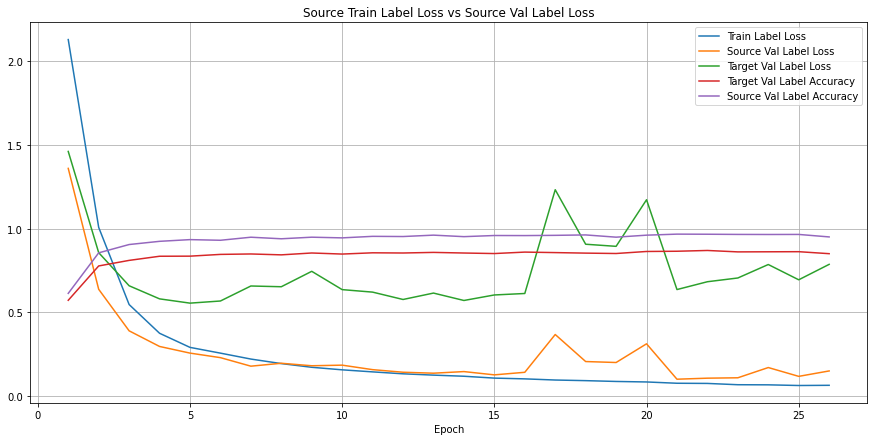

In [16]:
get_loss_curve(experiment)

<AxesSubplot:title={'center':'Results'}>

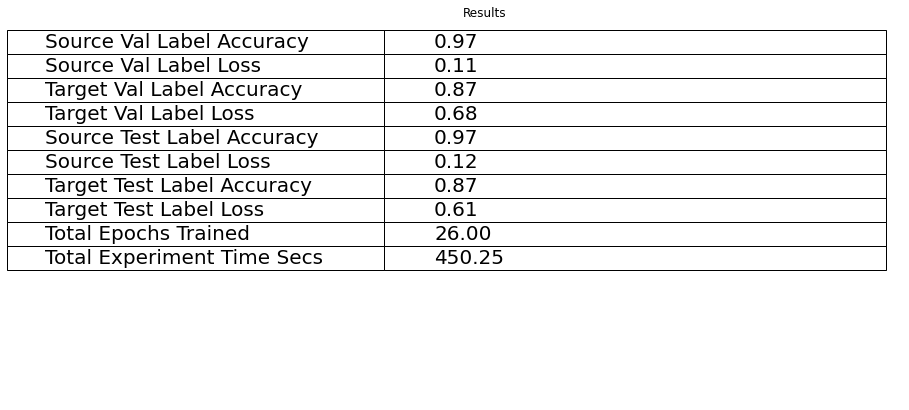

In [17]:
get_results_table(experiment)

<AxesSubplot:title={'center':'Per Domain Accuracy'}, xlabel='domain'>

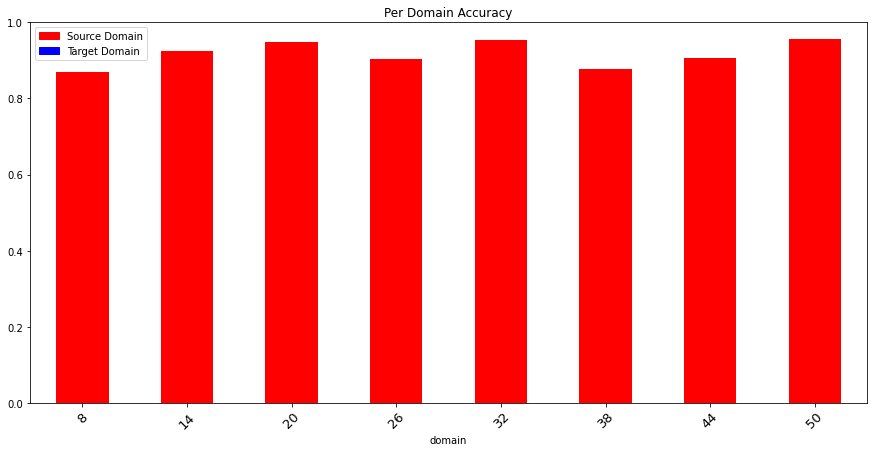

In [18]:
get_domain_accuracies(experiment)

In [19]:
print("Source Test Label Accuracy:", experiment["results"]["source_test_label_accuracy"], "Target Test Label Accuracy:", experiment["results"]["target_test_label_accuracy"])
print("Source Val Label Accuracy:", experiment["results"]["source_val_label_accuracy"], "Target Val Label Accuracy:", experiment["results"]["target_val_label_accuracy"])

Source Test Label Accuracy: 0.9672395833333334 Target Test Label Accuracy: 0.8687760416666667
Source Val Label Accuracy: 0.9661979166666667 Target Val Label Accuracy: 0.8690625


In [20]:
json.dumps(experiment)

'{"experiment_name": "cnn_3:oracle.run1.framed-oracle.run2.framed", "parameters": {"experiment_name": "cnn_3:oracle.run1.framed-oracle.run2.framed", "labels": ["3123D52", "3123D65", "3123D79", "3123D80", "3123D54", "3123D70", "3123D7B", "3123D89", "3123D58", "3123D76", "3123D7D", "3123EFE", "3123D64", "3123D78", "3123D7E", "3124E4A"], "domains_source": [8, 32, 50, 14, 20, 26, 38, 44], "domains_target": [8, 32, 50, 14, 20, 26, 38, 44], "pickle_name_source": "oracle.Run1_framed_2000Examples_stratified_ds.2022A.pkl", "pickle_name_target": "oracle.Run2_framed_2000Examples_stratified_ds.2022A.pkl", "device": "cuda", "lr": 0.0001, "batch_size": 128, "normalize_source": false, "normalize_target": false, "num_examples_per_domain_per_label_source": -1, "num_examples_per_domain_per_label_target": -1, "torch_default_dtype": "torch.float32", "n_epoch": 50, "patience": 3, "criteria_for_best": "target_accuracy", "x_net": [{"class": "nnReshape", "kargs": {"shape": [-1, 1, 2, 256]}}, {"class": "Conv2d